# Baseline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd


##### Infos
Input Layer: 256x216x3x1 \
n_mels, x_axis, channels, Anzahl

(256, 216, 3)


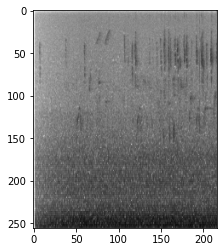

In [2]:
x = np.load("G:/Hochschule/birdclef2022/birdclef-2022/train_spectro/afrsil1/XC125458_0.npy")
print(x.shape)
plt.imshow(x)

Info: Alle drei Channel sind gleich!
3 Channel eigentlich RGB -> Aber Grauwerte


In [3]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import os
from torch.utils.data import random_split,Dataset, DataLoader

from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from sklearn.preprocessing import LabelEncoder

In [4]:
PATH_TO_BIRDCLEF = "birdclef-2022"
PATH_TO_SPECTRO = f"{PATH_TO_BIRDCLEF}/train_spectro"

1. numChannels: The number of channels in the input images (1 for grayscale or 3 for RGB)

Basic Setup des CNN

https://madebyollin.github.io/convnet-calculator/

In [5]:
class BirdDataSet(Dataset):

    def __init__(self, csv_file, root_dir):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.classes = self.data_frame['primary_label'].unique()

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])
        sample = np.load(sample_path)
        label = self.data_frame.iloc[idx, 0]
        return sample,label

In [6]:
class BirdNet(Module):
	# 3 Channels
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(BirdNet, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


		self.conv3 = Conv2d(in_channels=50, out_channels=80,
			kernel_size=(5, 5))
		self.relu3 = ReLU()
		self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv4 = Conv2d(in_channels=80, out_channels=110,
			kernel_size=(5, 5))
		self.relu4 = ReLU()
		self.maxpool4 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv5 = Conv2d(in_channels=110, out_channels=120,
			kernel_size=(5, 5))
		self.relu5 = ReLU()
		self.maxpool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=960, out_features=500)
		self.relu6 = ReLU()
		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)
		
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)

		x = self.conv3(x)
		x = self.relu3(x)
		x = self.maxpool3(x)

		x = self.conv4(x)
		x = self.relu4(x)
		x = self.maxpool4(x)

		x = self.conv5(x)
		x = self.relu5(x)
		x = self.maxpool5(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu6(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return the output predictions
		return output

In [7]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Laden der Splits

In [8]:
primary_label_list = []
split_paths_list = []
all_data = []
for primary_label in os.listdir(PATH_TO_SPECTRO):
    for spectro_split in os.listdir(f"{PATH_TO_SPECTRO}/{primary_label}"):
        all_data.append((primary_label,spectro_split))
        primary_label_list.append(primary_label)
        split_paths_list.append(f"{primary_label}/{spectro_split}")
print(f"{all_data[0]},{split_paths_list[0]},{primary_label_list[0]} ")

('afrsil1', 'XC125458_0.npy'),afrsil1/XC125458_0.npy,afrsil1 


In [9]:
dataset_frame = pd.DataFrame({'primary_label': primary_label_list,
                   'path': split_paths_list})
label_encoder = LabelEncoder()
primary_labels = label_encoder.fit_transform(dataset_frame['primary_label'])
dataset_frame['primary_label'] = primary_labels
dataset_frame.to_csv("annotation_data_2.csv", index=False)
dataset_frame.head()

,primary_label,path
0,0,afrsil1/XC125458_0.npy
1,0,afrsil1/XC125458_1.npy
2,0,afrsil1/XC125458_2.npy
3,0,afrsil1/XC175522_0.npy
4,0,afrsil1/XC175522_1.npy


## Erstellen der Trainingsdaten

In [10]:
data_set = BirdDataSet("annotation_data_2.csv",PATH_TO_SPECTRO)

numTrainSamples = round(len(data_set) * TRAIN_SPLIT)
numValSamples = round(len(data_set) * VAL_SPLIT)

(trainData, valData) = random_split(data_set,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))
print(f"{trainData}, {valData}")

<torch.utils.data.dataset.Subset object at 0x000001CD14719550>, <torch.utils.data.dataset.Subset object at 0x000001CD72554D00>


In [11]:
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [12]:
print("[INFO] initializing the LeNet model...")
model = BirdNet(
	numChannels=3,
	classes=len(data_set.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

[INFO] initializing the LeNet model...
[INFO] training the network...


# Dimensionsrechnungn in CNNs

Fehler
```
~\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\linear.py in forward(self, input)
    101 
    102     def forward(self, input: Tensor) -> Tensor:
--> 103         return F.linear(input, self.weight, self.bias)
    104 
    105     def extra_repr(self) -> str:

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1200 and 800x500)
```

Erklärung

64 -> BatchSize
1200 -> Output nach Faltung

800 -> Input Linear Layer
500 -> Output Layer 


Lösung \
Output nach Faltung ist der Input des Fully Connected Layers

Info \
Channel != Classes

Fehler \
Tupel kennt .to() nicht -> Labels enkodieren zu numerischen Werten


In [13]:
# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for data in trainDataLoader:
		x,y = data
		x = x.transpose(1,3)
		x = x.transpose(2,3)
		x = x.float()
		# send the input to the device
		x, y = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			x = x.transpose(1, 3)
			x = x.transpose(2, 3)
			x = x.float()
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

FileNotFoundError: [Errno 2] No such file or directory: 'birdclef-2022/train_spectro\\comsan/XC497333_128.npy'